# Image Colorization Final Project
Authors: Aret Tinoco, Keshav Gupta, Hal Halberstadt

Dataset: https://www.kaggle.com/datasets/darthgera/colorization

---

## Imports

We have to import some unsual libraries in order to get the RGB values of our target images into HSL format, and a few more for ease of viewing and on the same note ease displaying data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
from pathlib import Path
from PIL import Image # for resizing images

import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model, callbacks, utils
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from IPython.display import display, HTML

Ease of reading

In [2]:
pd.set_option('display.max_columns', 200)
pd.options.display.width = 120
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

Now to state the directory of the data to retrieve from.

In [3]:
data_dir = Path("C:/Users/smhal/Desktop/archive2") 
img_shape = (512, 512, 3)
# shrink_shape = img_shape
shrink_shape = (256, 256, 3)

folder_paths = ['color', 'bw', 'color_val', 'bw_val']

---

## Useful Functions

We need a function to make conversion of each image easier

In [4]:
def hls_conv(image, width=shrink_shape[0], height=shrink_shape[0]):
    for x in range(width):
        for y in range(height):            
            image[x][y] = colorsys.rgb_to_hls(image[x][y][0], image[x][y][1], image[x][y][2])
#     image[:,:,1:]/255
#     image[:,:,1] = 
    return image

In [107]:
def rbg_conv(image, width=shrink_shape[0], height=shrink_shape[0]):
    for x in range(width):
        for y in range(height):  
            image[x][y] = colorsys.hls_to_rgb(image[x][y][0], image[x][y][1], image[x][y][2])
#             image[x][y] /= 255.0
    return image

---

## Data Generator

Since we cannot hope to hold onto 18000 images in our kernel, we have to use a generator in order to be able to get data from the file and then train on that data.

In [6]:
class DataGenerator(utils.Sequence): 
    '''
    adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    
    Generates a color (rbg/hls) and black & white image for training data
    '''
    def __init__(self, list_IDs_color, list_IDs_bw, batch_size=1, 
                 dim=shrink_shape, n_channels=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs_bw
        self.list_IDs = list_IDs_color
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp_bw = [self.list_IDs[k] for k in indexes]
        list_IDs_temp_color = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp_bw, list_IDs_temp_color)
        
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp_bw, list_IDs_temp_color):
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp_bw):
            # B/W image
            img = load_img(ID)
            img = img.resize(shrink_shape[:2])
            _img = np.array(img, dtype=np.float32)
#             X[i] = _img
            X[i] = _img

            # target image
            img = load_img(list_IDs_temp_color[list_IDs_temp_color.index(ID)])
            img = img.resize(shrink_shape[:2])
            _img = np.array(img, dtype=np.float32)
#             y[i] = _img
            y[i] = hls_conv(_img)

        return X, y

In [7]:
# Dataset locations
bw_dir_train = data_dir / folder_paths[1]
color_dir_train = data_dir / folder_paths[0]

partition_bw = list(bw_dir_train.glob('*.jpg'))
partition_color = list(bw_dir_train.glob('*.jpg'))

# Generators
training_generator = DataGenerator(partition_bw, partition_color)

In [8]:
# Dataset locations
bw_dir_val = data_dir / folder_paths[3]
color_dir_val = data_dir / folder_paths[2]

partition_bw = list(bw_dir_val.glob('*.jpg'))
partition_color = list(color_dir_val.glob('*.jpg'))

# Generators
validation_generator = DataGenerator(partition_bw, partition_color)

---

## Model(s)

Next I want to read the data from the files and then just to make sure I am getting the right data from the right files

In [9]:
K.clear_session()  # Just for sanity

act_fun='relu'
filters = 3
filter_size = 3
pool_size = 2
# layer_input_shape = (shrink_shape[0], shrink_shape[1], 1)
layer_input_shape = shrink_shape

_input = Input(layer_input_shape)

'''first head'''
h1 = layers.SeparableConv2D(filters, filter_size, padding='same', activation=act_fun, name="head_1_conv_1")(_input) # hue
# h1 = layers.AveragePooling2D(pool_size=pool_size, padding="valid", name="head_1_pooling_1")(h1)

h1 = layers.SeparableConv2D(filters+2, filter_size, padding='same', activation=act_fun, name="head_1_conv_2")(h1)
h1 = layers.SeparableConv2D(1, filter_size, padding='same', activation=act_fun, name="head_1_conv_3")(h1)
                 
'''second head'''                                                              
h2 = layers.SeparableConv2D(filters, filter_size, padding='same', activation=act_fun, name="head_2_conv_1")(_input) # saturation
# h2 = layers.AveragePooling2D(pool_size=pool_size, padding="valid", name="head_2_pooling_1")(h2)

h2 = layers.SeparableConv2D(filters+2, filter_size, padding='same', activation=act_fun, name="head_2_conv_2")(h2)
h2 = layers.SeparableConv2D(1, filter_size, padding='same', activation=act_fun, name="head_2_conv_3")(h2)
         
'''third head'''                                                                     
# h3 = (_input) # light
h3 = layers.SeparableConv2D(filters, filter_size, padding='same', activation=act_fun, name="head_3_conv_1")(_input) # light
# h3 = layers.AveragePooling2D(pool_size=pool_size, padding="valid", name="head_3_pooling_1")(h3)

# h3 = layers.SeparableConv2D(filters+2, filter_size, padding='same', activation=act_fun, name="head_3_conv_2")(h3)
# h3 = layers.SeparableConv2D(1, filter_size, padding='same', activation=act_fun, name="head_3_conv_3")(h3)

'''full image'''
full_input = layers.Concatenate(axis=3)([h1, h3, h2]) # [hue, light, saturation)]
x = layers.SeparableConv2D(filters, filter_size, padding='same', activation=act_fun, name="full_conv_1")(full_input)
# x = layers.SeparableConv2D(filters*2, filter_size, padding='same', activation=act_fun, name="full_conv_2")(x)
# x = layers.AveragePooling2D(pool_size=pool_size, padding="valid", name="full_pooling_1")(x)
# x = layers.SeparableConv2D(filters+1, filter_size, padding='same', activation=act_fun, name="full_conv_3")(x)
x = layers.SeparableConv2D(3, filter_size, padding='same', activation=act_fun)(x)

pred = x
model = Model(_input, pred)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
head_1_conv_1 (SeparableConv2D) (None, 256, 256, 3)  39          input_1[0][0]                    
__________________________________________________________________________________________________
head_2_conv_1 (SeparableConv2D) (None, 256, 256, 3)  39          input_1[0][0]                    
__________________________________________________________________________________________________
head_1_conv_2 (SeparableConv2D) (None, 256, 256, 5)  47          head_1_conv_1[0][0]              
______________________________________________________________________________________________

---

## Training

Creating a loss function

In [11]:
def my_loss_fn(y_true, y_pred):
    sum_error = y_true - y_pred
    tf.Variable(sum_error)
    return tf.sqrt(sum_error)

In [12]:
model.compile(optimizer='rmsprop', loss='mse',  metrics=['accuracy'])

history = model.fit(training_generator, validation_data=validation_generator, epochs=1)

18000/18000 [==============================] - 5557s 309ms/step - loss: 80.8263 - accuracy: 0.9820 - val_loss: 3.2795 - val_accuracy: 0.9938


---

## Example Results

Here is a few images that were colorized with this model

In [89]:
image_number = 1

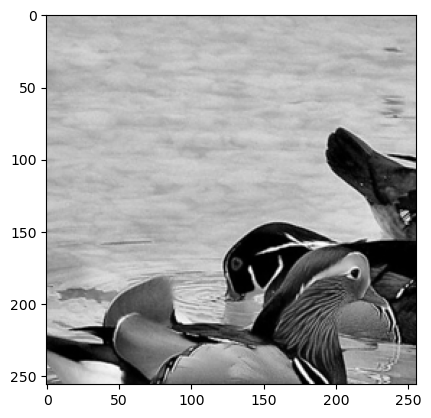

In [90]:
imgs = np.zeros((10, shrink_shape[0], shrink_shape[1], shrink_shape[2]), dtype='float32')
i = 0
for location in partition_bw[:10]:
    img = load_img(location)
    img = img.resize(shrink_shape[:2])
    _img = np.array(img, dtype=np.float32)
    imgs[i] = _img/255
    i += 1
    
plt.imshow(imgs[image_number]);

[0.        0.9567885 0.       ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.1518219 1.1518219 1.1518219]


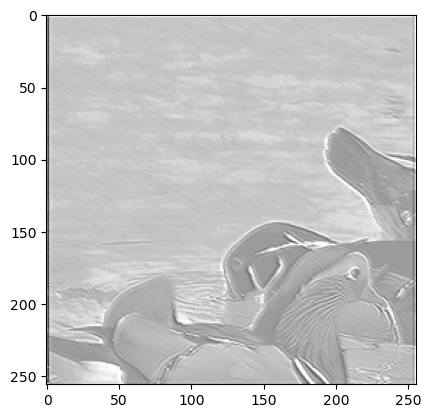

In [118]:
output = model.predict(imgs)
print(output[0][0][0])
for hls_img in output:
    hls_img = rbg_conv(hls_img)
print(hls_img[0][0])

plt.imshow(output[image_number]);

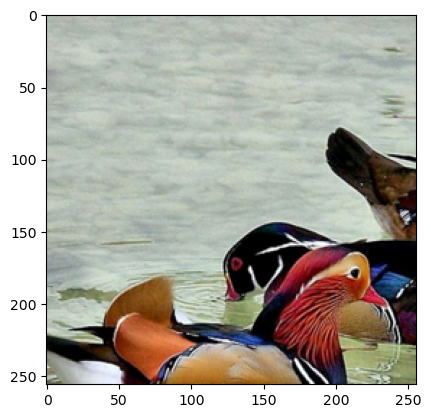

In [92]:
imgs_c = np.zeros((10, shrink_shape[0], shrink_shape[1], shrink_shape[2]), dtype='float32')
i = 0
for location in partition_color[:10]:
    img_c = load_img(location)
    img_c = img_c.resize(shrink_shape[:2])
    _img_c = np.array(img_c, dtype=np.float32)
    imgs_c[i] = _img_c/255
    i += 1
    
plt.imshow(imgs_c[image_number]);

---

## Conclusions

Para1...